# NFL Fantasy Player Ranking

The goal of this project is to be able to rank fantasy players based on past statistics. We will use clustering algorithmns to be able to rank players into distinguishable tiers. Ideally, this model can be used weekly throughout the NFL season based on solely this seasons performance.

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

### Initial Data importing and cleanup

In [2]:
#importing data
stats = pd.read_csv('fantasy.txt')

#replacing all NAs with 0
stats.fillna(value = 0, inplace = True)

#filtering for players that only had greater than 0 points
stats = stats[stats.FantPt >= 16]

#first we will reorder the dataframe from highest to lowest points scored
#normal leagues
stats_norm = stats.sort_values('FantPt', ascending = False)

#ppr leagues
stats_ppr = stats.sort_values('PPR', ascending = False)

#cleaning up player column
#normal league
stats_norm['Player'] = stats_norm['Player'].str.split('*').str[0].str.split('\\').str[0]

#ppr league
stats_ppr['Player'] = stats_ppr['Player'].str.split('*').str[0].str.split('\\').str[0]

#std predictors
std_predictors = ['Player', 'G', 'GS', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'Att.1',
                  'Yds.1', 'Y/A', 'TD.1', 'Tgt', 'Rec', 'Yds.2', 'Y/R',
                  'TD.2', 'Fmb', 'FL', 'TD.3', '2PM', '2PP', 'FantPt']
#ppr predictors 
ppr_predictors = ['Player', 'G', 'GS', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'Att.1',
                  'Yds.1', 'Y/A', 'TD.1', 'Tgt', 'Rec', 'Yds.2', 'Y/R',
                  'TD.2', 'Fmb', 'FL', 'TD.3', '2PM', '2PP','PPR']

#all relevant predictors to use for std PCA
df_std = stats.filter(items = std_predictors)

#all relevant predictors to use for PPR PCA
df_ppr = stats.filter(items = ppr_predictors)

#storing index as player names for std
df_std.set_index('Player', inplace = True)

#storing index as player names for ppr
df_ppr.set_index('Player', inplace = True)

#standardizing data
#STD standardizing data
df_std = StandardScaler().fit_transform(df_std)

#PPR standardizing data
df_ppr = StandardScaler().fit_transform(df_ppr)

E:\Code\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\Code\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
E:\Code\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\Code\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Principial Component Analysis

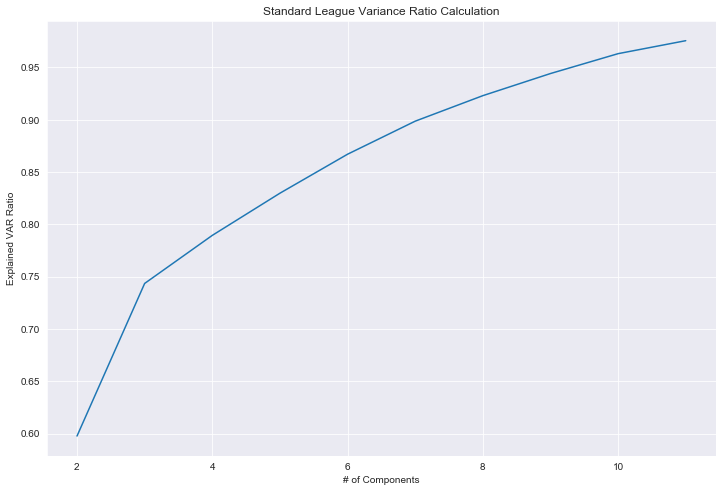

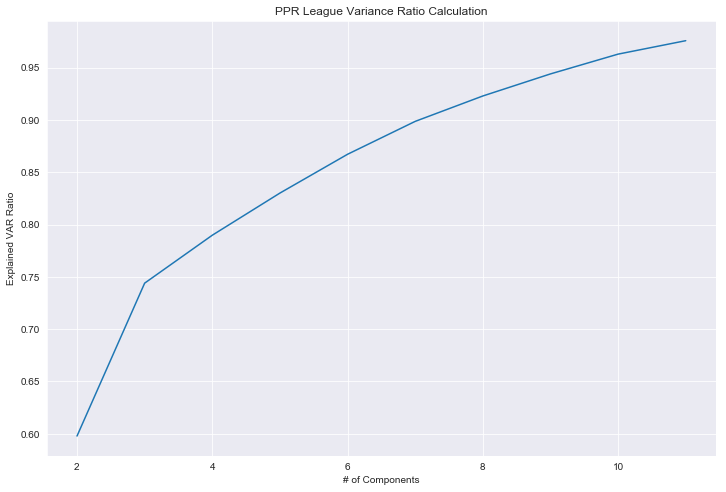

In [3]:
#function that allows us to do PCA and returns its variance ratio and a graph
#The parameters are:
#x - which is the maximum number of components
#data - the data in question that we are performing PCA
#df_name - name that will be used as title for graph

def pca_variance_check(x, data, df_name):
    #empty list to store variance ratio
    pca_variance_list = []

    #for loop that serachs for best ratio

    for i in range(2,x):
        pca = PCA(i, random_state = 0)
        components = pca.fit_transform(data)
        pca_variance = sum(pca.explained_variance_ratio_)
        pca_variance_list.append(pca_variance)

    #plotting our variance
    #changing style
    sns.set_style('darkgrid')

    #changing fig size
    plt.figure(figsize = (12,8))

    #plotting our variance
    ax = sns.lineplot(range(2,x), pca_variance_list)

    #plot labels
    ax.set(xlabel = '# of Components', ylabel = 'Explained VAR Ratio', 
           title = df_name + ' Variance Ratio Calculation')
    return(pca_variance_list)
    
std_var = pca_variance_check(12, df_std, 'Standard League')
ppr_var = pca_variance_check(12, df_ppr, 'PPR League')

So luckily for us both graphs have VERY similar VAR ratio explained so what we will do is use a fixed number of components for each type of scoring. Since we can't tell much from these graphs we will instead calculate the difference between components. So, the difference between 4 to 5, 5 to 6, etc. (essentially the derivative at each point.

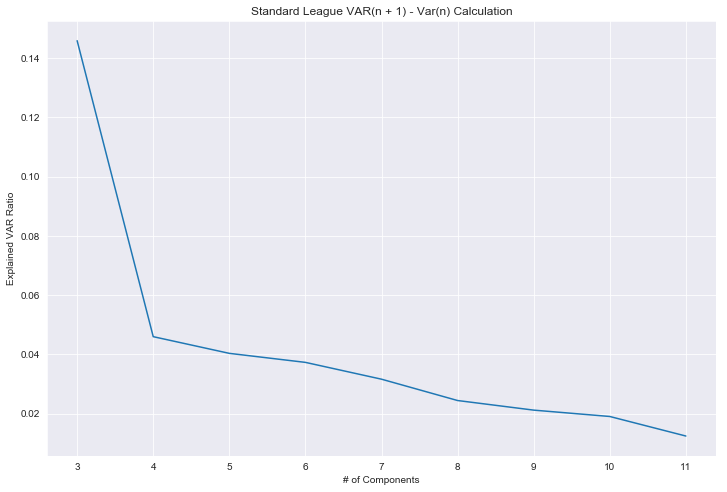

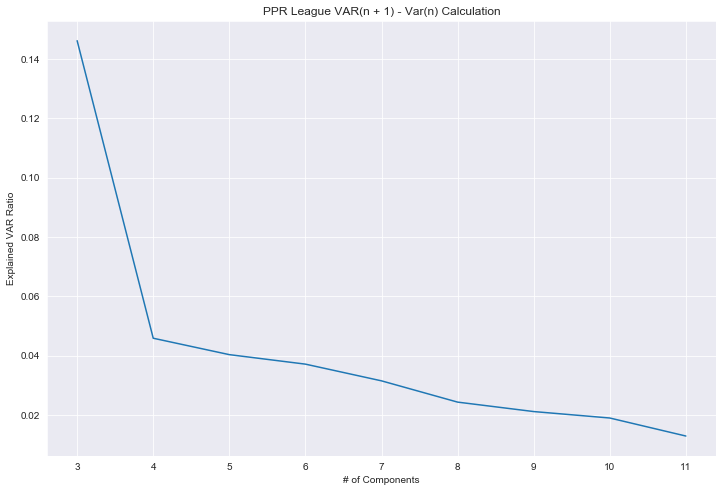

In [4]:
#function that calculates the difference between components and prints a graph
#the parameters are:
#data - list of VAR ratio
#df_name - name that will be used as title for graph

def component_diff(data, df_name):
    #calculating difference
    dy = np.diff(data)

    #changing fig size
    plt.figure(figsize = (12,8))

    #plotting our variance
    ax = sns.lineplot(range(3,12), dy)

    #plot labels
    ax.set(xlabel = '# of Components', ylabel = 'Explained VAR Ratio',
           title = df_name + ' VAR(n + 1) - Var(n) Calculation')
    return(dy)

std_diff = component_diff(std_var, 'Standard League')
ppr_diff = component_diff(ppr_var, 'PPR League')

As we can see there is a sharp decrease as we move from 4 components to 5 components. This tells us that when we increase our number of principal components from 4 to 5 our explained variance ratio only increases slightly. So, to keep our model simplier we will use 4 components.

So do PCA for STD vs PPR leagues,
Give each data frame Player name as index and position.
Then subset all the dataframe into each position and use GMM on said.

In [5]:
#function that will gets us a df into 4 components using PCA
#parameters are:
#data - data to perform PCA on
#index_names - name of index (player names in this case)
#position_names - positions of players

def pca_4(data, index_names, position_names):
    #running PCA
    pca = PCA(n_components = 4)

    #getting our components
    components = pca.fit_transform(data)

    #getting our new dataframe
    pca_df = pd.DataFrame(components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])

    #adding player names
    pca_df['Player'] = index_names
    
    #adding positions
    pca_df['Position'] = position_names

    #converting player names to index values
    pca_df.set_index('Player', inplace = True)

    #checking our variance ratio
    var_sum = sum(pca.explained_variance_ratio_)
    
    return(pca_df, var_sum)

df_std, b = pca_4(df_std, stats_norm.Player, stats_norm.FantPos)
df_ppr, b2 = pca_4(df_ppr, stats_ppr.Player, stats_norm.FantPos)

# FILTER THESE PLAYERS BASED ON POSITION

In [6]:
#filtering players based on position

#poisitions list to parse through
positions = ['QB', 'RB', 'WR', 'TE']

#empty dict to store individual position data for normal leagues
stats_norm_pos = {}
stats_ppr_pos = {}

#for loop that stores each position data into dict
for position in positions:
    stats_norm_pos[position] = df_std[df_std.Position == position]
    stats_ppr_pos[position] = df_ppr[df_ppr.Position == position]

#now we remove the position column for each position
for position in positions:
    stats_norm_pos[position] = stats_norm_pos[position].drop(columns = ['Position'])
    stats_ppr_pos[position] = stats_ppr_pos[position].drop(columns = ['Position'])
    

# Gaussian Mixture Modeling

For our first model we will be using Gaussian Mixture. Just like when we used PCA we need to find the right number of clusters. In order to do so we will look at silhouette scores.

In [7]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

#function that takes in a dataframe and returns a range of silhouette scores and plots them
#The parameters are:
#x - which is the maximum number of components
#data - the data in question that we are performing PCA
#df_name - name that will be used as title for graph

def gmm_silhouette_score(x, data, df_name):
    #list to hold silhouette scores
    silhouette_gmm = []

    #we will look from 4 to 10 clusters
    for j in range(2, x):
        gmm = GaussianMixture(n_components = j, random_state = 0).fit(data)
        #get labels
        labels = gmm.predict(data)
        #insert score into list
        silhouette_gmm.append(silhouette_score(data, labels))

    #plotting our silhouette scores for readability.

    #changing fig size
    plt.figure(figsize = (10,6))

    #plotting our variance
    ax = sns.lineplot(range(2,x), silhouette_gmm)

    #plot labels
    ax.set(xlabel = '# of Clusters', ylabel = 'Silhouette Scores', 
       title = df_name + ' Cluster Silhouette Scores')
    plt.show()

Now that we have our function to get silhouette scores we will use this for each position. Instead of performing a massive cluster on every single player, to get more accurate results we will check silhouette scores using only the data from that specific position. Since we have Standard AND PPR score we will perform this twice for each position (QB, RB, WR, TE) for a total of 8 times. For each position we will pick the highest silhouette scores (in the 4-8 cluster range) to maximize our clustering effectiveness, which will hopefully allow us to obtain tiers.

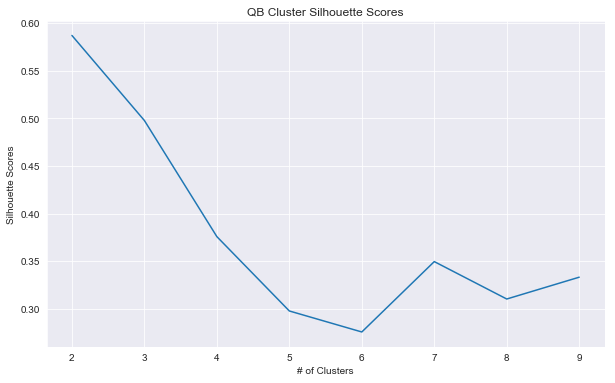

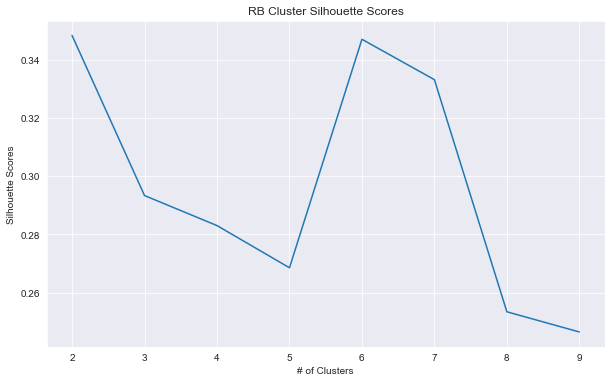

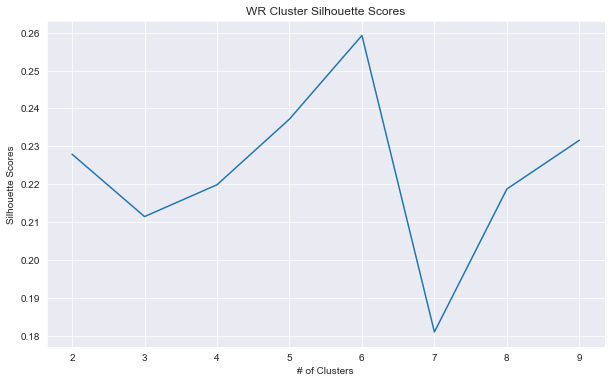

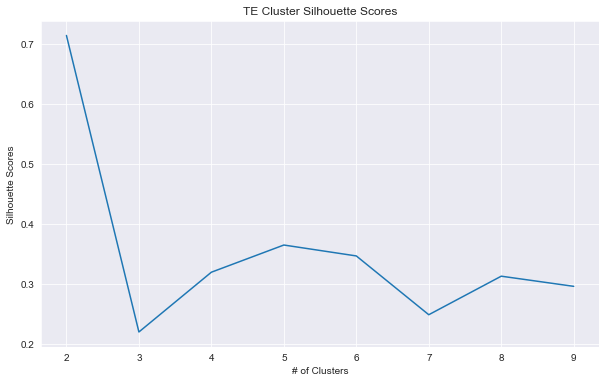

In [8]:
for position in positions:
    gmm_silhouette_score(10, stats_norm_pos[position], position)

According to this we will have:

    7 Clusters - QB
    6 Clusters - RB
    6 Clusters - WR
    5 Clusters - TE.
    
Now for the Standard League.

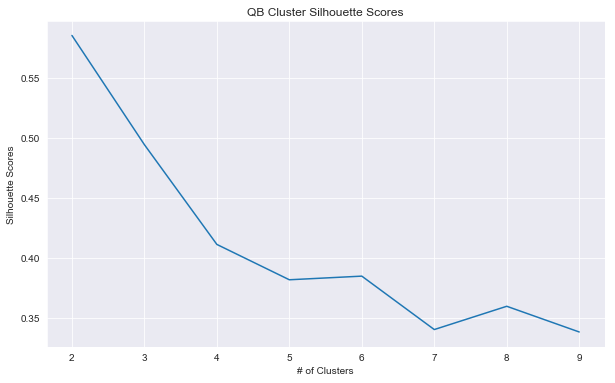

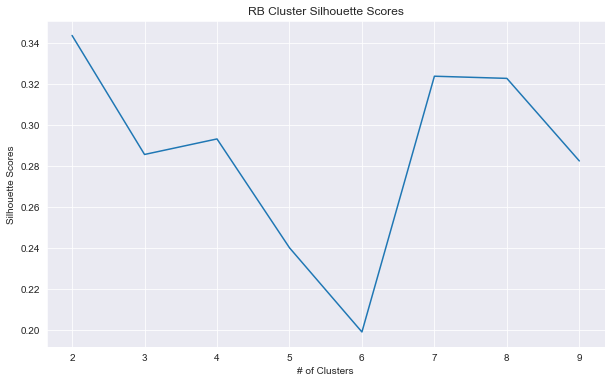

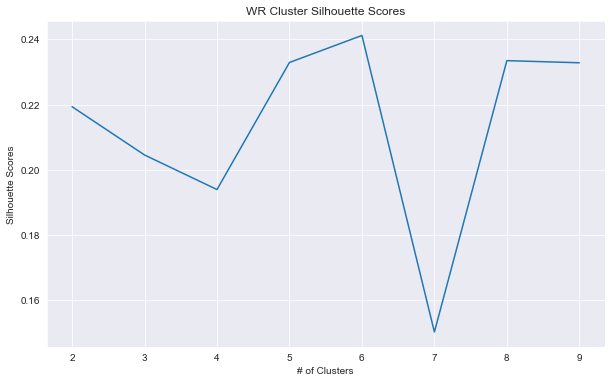

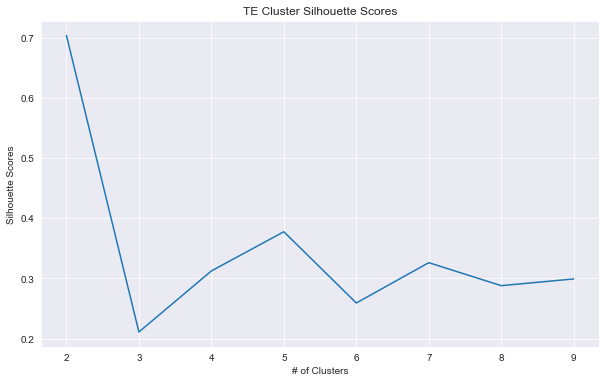

In [9]:
for position in positions:
    gmm_silhouette_score(10, stats_ppr_pos[position], position)

According to this we will have:

    5 Clusters - QB
    7 Clusters - RB
    6 Clusters - WR
    5 Clusters - TE.
    
For the PPR Leagues.

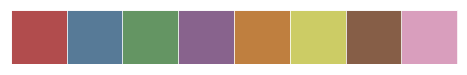

In [10]:
#setting color palette
current = sns.color_palette(sns.palplot(sns.color_palette("Set1", n_colors=8, desat=.5)))

In [11]:
#changing fig size
#plt.figure(figsize = (16,12))
#ax = sns.scatterplot(stats_norm_pos['QB']['PC 1'], stats_norm_pos['QB']['PC 2'], hue = labels, legend = 'full', 
 #               palette = current[0:7])

#for i, txt in enumerate(stats_norm_pos['QB'].index.values):
 #   ax.annotate(txt, (stats_norm_pos['QB']['PC 1'][i]+0.25, stats_norm_pos['QB']['PC 2'][i]+0.2))

In [12]:
#list of positions to parse
position = ['QB', 'RB', 'WR', 'TE']

#standard clusters for each position
std_clusters = [7, 6, 6, 5]

#ppr clusters for each position
ppr_clusters = [5, 7, 6, 5]

#STD League clustering based on each position
for i, j in zip(std_clusters, positions):
    #gmm using their respective clusters
    gmm = GaussianMixture(n_components = i, covariance_type = 'full', random_state = 0).fit(stats_norm_pos[j])
    #labeling our points based on GMM
    labels = gmm.predict(stats_norm_pos[j])
    #storing labels to our dataset
    stats_norm_pos[j]['Cluster'] = labels    

In [13]:
#PPR League clustering based on each position
for k, l in zip(ppr_clusters, positions):
    #gmm using their respective clusters
    gmm = GaussianMixture(n_components = k, covariance_type = 'full', random_state = 0).fit(stats_ppr_pos[l])
    #labeling our points based on GMM
    labels = gmm.predict(stats_ppr_pos[l])
    #storing labels to our dataset
    stats_ppr_pos[l]['Cluster'] = labels

In [43]:
#adding positions to each dataframe
for i in positions:
    stats_norm_pos[i]['Position'] = i
    stats_ppr_pos[i]['Position'] = i
    stats_norm_pos[i]['League'] = 'STD'
    stats_ppr_pos[i]['League'] = 'PPR'

#std league concatenating dataframe into one
current = stats_norm_pos['QB']
std_final = current.append(stats_norm_pos['RB'])
std_final = std_final.append([stats_norm_pos['WR']])
std_final = std_final.append([stats_norm_pos['TE']])

#ppr league concatenating dataframe into one
current = stats_ppr_pos['QB']
ppr_final = current.append(stats_ppr_pos['RB'])
ppr_final = ppr_final.append([stats_ppr_pos['WR']])
ppr_final = ppr_final.append([stats_ppr_pos['TE']])

#final concatenation
final_df = std_final.append(ppr_final)
final_df

#saving dataframe onto desktop
final_df.to_excel(r'C:\Users\Jeet\Desktop\fantasy_rankings.xlsx')

Now we move on to Tableau to create visuals of our clustered players.